In [ ]:
!nvidia-smi

Tue Aug 10 18:53:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np

class MyDataset(Dataset):
    """ A custom CIFAR10 dataset having only 2 classes, ship and truck"""
    def __init__(self, root='./data', train=True, download=True, transform=None):
        
        self._cifar10 = torchvision.datasets.CIFAR10(root=root, train=train,
                                                download=download)  

        self.transform = transform

        self._data = self._cifar10.data
        self._targets = self._cifar10.targets
        self.data, self.targets = self.__remove__()

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        data = self.transform(data)
        return data, target
    
    def __len__(self):
        return len(self.data)

    def __get_remove_list(self):
        """ return the list of indecies of data points to be deleted """

        remove_list = []
        needed_labels = [8, 9] # Labels for: ship, truck
        for idx, label in enumerate(self._targets):
            if label not in needed_labels:
                remove_list.append(idx)
        return remove_list
        
    def __remove__(self):
        """ remove datapoints from indicies returned frim get_remove_lisr function
        targets are made into 0 and 1 insted of 8 and 9. 1->ship, 0->truck """

        remove_list = self.__get_remove_list()
        data = np.delete(self._data, remove_list, axis=0)
        targets_temp = np.delete(self._targets, remove_list, axis=0)
        targets = np.subtract(targets_temp, 8)

        return data, targets
    

In [ ]:
batch_size = 64

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = MyDataset(transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = MyDataset(train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)
classes = ('ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


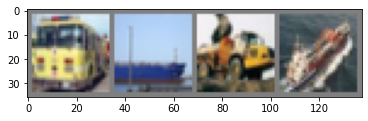

truck ship truck ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))#print(trainset.targets)
# print label1
print(' '.join(classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

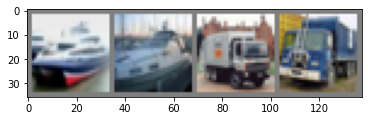

GroundTruth:   ship  ship truck truck


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship truck truck  ship


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class ship  is: 100.0 %
Accuracy for class truck is: 0.0 %


In [ ]:
with torch.no_grad():
  img = images[0]
  img = torch.unsqueeze(img, 0)
  pred = net(img)
  print(pred.tolist())
  pred = torch.nn.functional.softmax(pred[0]).tolist()
  pred[0], pred[1] = round(pred[0], 2), round(pred[1], 2)

  print(pred)

[[-0.007533257827162743, -0.02559339813888073]]
[0.5, 0.5]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
